In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

%matplotlib inline

In [2]:
# 할당된 모든 GPU 사용하는 코드
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    model_name = 'Xception_17class'    
    class_num = 17
    batch_size = 32
    target_size=(200,200)
    epochs = 5
    
    gen = ImageDataGenerator(rescale=1/255.)
    train_gen = gen.flow_from_directory('./data/train/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
    valid_gen = gen.flow_from_directory('./data/valid/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
    test_gen = gen.flow_from_directory('./data/test/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

    transfer_base = Xception(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    model = models.Sequential()
    model.add(transfer_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(class_num, activation='softmax'))
    transfer_base.trainable = False
    
    #폴더생성
    if 'save_models' not in os.listdir(): os.mkdir('save_models')
    #모델 저장 path
    dir_path = "./save_models/"
    path_checkpoint = dir_path+model_name+"_{epoch:04d}.h5" 
    #모델 저장 코드(weight만 저장)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
    modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, save_freq='epoch')
    #ensemble을 위해 5epoch마다 저장

    #fit
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
    history = model.fit(train_gen, validation_data=valid_gen, batch_size=batch_size, epochs=epochs, callbacks=[es_callback, modelckpt_callback])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Found 52020 images belonging to 17 classes.
Found 17340 images belonging to 17 classes.
Found 17340 images belonging to 17 classes.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Red

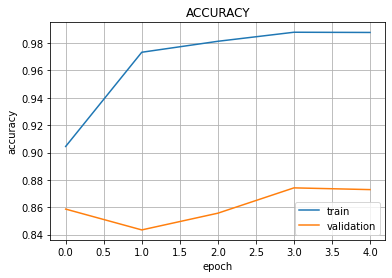

In [3]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['train','validation'], loc = 'best')

In [4]:
# 할당된 모든 GPU 사용하는 코드
with strategy.scope():
    #최고 성능 모델 불러오기
    idx = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    file = [i for i in os.listdir('save_models') if i.startswith(model_name)][idx]
    latest = tf.train.latest_checkpoint(dir_path)
    model_loaded = tf.keras.models.load_model(dir_path+file)

    #test score 확인
    loss, acc = model_loaded.evaluate(test_gen) 

    print('Test loss:', loss) 
    print('Test accuracy:', acc)

542/542 [==============================] - 22s 41ms/step - loss: 0.7517 - accuracy: 0.8740
Test loss: 0.7516604661941528
Test accuracy: 0.8740484714508057
